# Troubleshooting ambulance service shape files

There are a few random specks in the ambulance service shapes when plotted with edge colour on:

![](figures/ambo_services_boundary_problems.png)

These specks appear where the dissolve function has not quite combined the shapes properly, possibly because there are tiny tiny gaps between the original LSOA shapes and so the combined shape contains a tiny hole.

This notebook tests a few ways to remove these specks.


## Method

__Test 1:__ For the ambulance 2021 shapes, we can avoid the specks by building up the data from the CCG 2015 boundaries instead. We know that the shapes match perfectly and there are fewer larger CCG 2015 than there are LSOA 2011, so fewer opportunities for tiny gaps. This method does result in an ambulance shape file without noticeable specks.
+ Wales does not contain any CCG 2015. We can copy across the Welsh shape built up from LSOA 2011. Possibly this method will create multiple small gaps between the English and Welsh shapes.

For the ambulance 2022 shapes, we do not have any data that perfectly matches the ambulance service boundaries in all cases.
+ The SICBL 2022 boundaries have changed from the CCG 2015 equivalents near Kettering (EMAS) and Peterborough (EEAST) and near Manchester (NWAS) and Derbyshire (EMAS), so the CCG 2015 shapes no longer perfectly match the ambulance boundaries in all cases.
+ __Test 2:__ The SICBL 2022 shapes cannot be used directly because of the problems with large shapes crossing ambulance service boundaries (Hampshire and Isle of Wight in SCAS and IWAS, and Milton Keynes and Bedfordshire in SCAS and EEAST).
    + For these affected areas, the SICBL 2022 shapes are identical to the CCG 2021 shapes which are built up of multiple CCG 2015 shapes.
    + However, the CCG 2015 coordinates don't seem to exactly match the LSOA 2011 coordinates (due to rounding area when generalised?).
    + Combining some shapes built from LSOA 2011 with other shapes built from CCG 2015 introduces very many small gaps where the two sources meet.
    + This can be somewhat prevented by buffering the shapes - expand the whole ambulance service multipolygon outwards by a few metres, and then shrink it back in - but this also changes the shapes around coasts and rivers and probably only introduces more small gaps between ambulance service polygons.
        + e.g. `gdf['geometry'] = gdf['geometry'].buffer(b).buffer(-b)` for b in metres and with gdf in a coordinate reference system that uses metres (British National Grid works, lat/long doesn't).
+ __Test 3:__ Potentially the Isle of Wight could be split off from the larger SICBL 2022 shape by exploding the MultiPolygon into its constituent polygons, identifying those that belong to the Isle of Wight, and making a new group of Hampshire polygons and a new group of Isle of Wight polygons. Remember to check separately for the Needles and Portsmouth sea forts to see what comes under the Isle of Wight 2015 CCG and what comes under the mainland Hampshire CCGs. This could be done most easily by finding the y-coordinates of all polygons and picking out all with a most southernly point below the most southernly point of the Hampshire coast.
    + This method cannot be used to split off Milton Keynes because the Milton Keynes polygon isn't stored separately in the SICBL 2022 shapes.

The tiny gaps between LSOA could probably be avoided by using the full extent LSOA boundaries.
+ However the file size is well over 800MB (!!), so presumably the resulting ambulance service shape file would also be pretty hefty considering its contents.
+ I don't know the exact steps used by the ONS to turn a full extent shape file into any of the more generalised or clipped options and so could not recreate the generalised boundaries from the full extent boundaries.
+ Potentially the full extent ambulance service boundaries could be calculated and then all coordinates compared with the closest coordinates in the generalised LSOA file. The generalised coordinates could then replace the matching full extent coordinates. This might well reintroduce small gaps between the ambulance service boundaries even if it is possible to get this working reliably without mistakes.

The gaps do not disappear if the coordinate reference system is swapped to lat/long before dissolving shapes.

## Notebook setup

In [12]:
# Import required packages
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import geopandas as gpd

# # Linting
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [17]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    image = './external_images'
    data = './data'
    dir_figures = 'figures'
    
    demographic = 'demographic'
    ccg_to_amb = 'ambulance_service_info_ccg_lookup.csv'

    dir_ons_geojson = './data/shapefiles/'
    lsoa11_geojson = 'LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3.geojson'
    ccg15_geojson = 'Clinical_Commissioning_Groups_July_2015_GCB_in_England_2022.geojson'
    ccg21_geojson = 'Clinical_Commissioning_Groups_April_2021_EN_BGC_2022.geojson'
    sicbl22_geojson = 'SICBL_JUL_2022_EN_BGC.geojson'

    lsoa_ambo_results = 'lsoa_ambo_lookup.csv'
    
    ccg15_amb_lookup = 'ccg15_amb.csv'
    sicbl22_amb_lookup = 'sicbl22_amb.csv'
    ccg21_amb_lookup = 'ccg21_amb.csv'

    ambo_name_dict = 'ambulance_service_names.csv'

paths = Paths()

Setup for plots.

Colours for ambulance regions:

In [29]:
# Various seaborn colorblind colours:
c1 = '#0072B2'
c2 = '#009E73'
c3 = '#F0E442'
c4 = '#56B4E9'

# Ambulance service colours:
amb_colour = pd.Series({
    'EEAST': c1,
    'EMAS': c2,
    'IWAS': c1,
    'LAS': c4,
    'NEAS': c2,
    'NWAS': c3,
    'SCAS': c3,
    'SECAmb': c2,
    'SWAS': c2,
    'WMAS': c1,
    'YAS': c1,
    'WAST': c4,
})
amb_colour.name = 'amb_colour'

Labels for ambulance regions:

In [7]:
dict_amb_service_name = pd.read_csv(os.path.join(paths.data, paths.ambo_name_dict), index_col=0).squeeze()

dict_amb_service_name

ambulance_service
EMAS         East Midlands
EEAST      East of England
IWAS         Isle of Wight
LAS                 London
NEAS            North East
NWAS            North West
SCAS         South Central
SECAmb    South East Coast
WMAS         West Midlands
SWAS            South West
WAST                 Welsh
YAS              Yorkshire
Name: ambulance_service_name, dtype: object

Label placement and colours:

In [8]:
df_annotations = pd.DataFrame(
    [
        ['EEAST', 730000, 280000],
        ['EMAS', 620000, 390000],
        ['IWAS', 510000, 70000],
        ['LAS', 650000, 195000],
        ['NEAS', 500000, 580000],
        ['NWAS', 250000, 450000],
        ['SCAS', 380000, 50000],
        ['SECAmb', 670000, 90000],
        ['SWAS', 170000, 160000],
        ['WMAS', 170000, 270000],
        ['YAS', 570000, 490000],
        ['WAST', 200000, 300000],
    ],
    columns=['ambulance_service', 'x_label', 'y_label']
)

# Add full ambulance service name, based on the data dictionary
df_annotations['label'] = (
    df_annotations['ambulance_service'].map(dict_amb_service_name))

# Add colours
df_annotations['amb_colour'] = (
    df_annotations['ambulance_service'].map(amb_colour))

Function to plot the labels:

In [28]:
def plot_annotations(df_annotations):
    for i in range(len(df_annotations)):
        plt.annotate(
            df_annotations.loc[i, 'label'],
            xy=(df_annotations.loc[i, 'x_label'], df_annotations.loc[i, 'y_label']),
            weight='bold',
            bbox=dict(facecolor=df_annotations.loc[i, 'amb_colour']),
            ha='center', va='center'
        )

## Load data

Ambulance region boundaries we made previously:

In [29]:
gdf_ambo21_lsoa = gpd.read_file('ambulance_catchment_2021.geojson')
gdf_ambo21_lsoa = gdf_ambo21_lsoa.set_index('ambo21')

# Merge in colours for plotting:
gdf_ambo21_lsoa.index.name = 'ambulance_service'
gdf_ambo21_lsoa = pd.merge(gdf_ambo21_lsoa, amb_colour, left_index=True, right_index=True, how='left')
gdf_ambo21_lsoa.index.name = 'ambo21'

gdf_ambo21_lsoa.head()

,geometry,amb_colour
ambo21,,
EEAST,"MULTIPOLYGON (((504078.594 192959.141, 504011....",#0072B2
EMAS,"MULTIPOLYGON (((433452.973 296575.368, 432482....",#009E73
IWAS,"MULTIPOLYGON (((450897.496 75508.595, 450613.3...",#0072B2
LAS,"MULTIPOLYGON (((510797.375 170600.422, 510753....",#56B4E9
NEAS,"MULTIPOLYGON (((417925.732 515867.666, 417905....",#009E73


In [30]:
gdf_ambo22_lsoa = gpd.read_file('ambulance_catchment_2022.geojson')
gdf_ambo22_lsoa = gdf_ambo22_lsoa.set_index('ambo22')

# Merge in colours for plotting:
gdf_ambo22_lsoa.index.name = 'ambulance_service'
gdf_ambo22_lsoa = pd.merge(gdf_ambo22_lsoa, amb_colour, left_index=True, right_index=True, how='left')
gdf_ambo22_lsoa.index.name = 'ambo21'

gdf_ambo22_lsoa.head()

,geometry,amb_colour
ambo21,,
EEAST,"MULTIPOLYGON (((504078.594 192959.141, 504011....",#0072B2
EMAS,"MULTIPOLYGON (((427187.406 311340.906, 427226....",#009E73
IWAS,"MULTIPOLYGON (((450897.496 75508.595, 450613.3...",#0072B2
LAS,"MULTIPOLYGON (((510797.375 170600.422, 510753....",#56B4E9
NEAS,"MULTIPOLYGON (((417925.732 515867.666, 417905....",#009E73


ONS health boundary shapes:

In [23]:
# Import CCG 2015 boundaries:
gdf_ccg15 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [31]:
# Import CCG 2015 boundaries:
gdf_ccg21 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg21_geojson))

In [32]:
# Import CCG 2015 boundaries:
gdf_sicbl22 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.sicbl22_geojson))

## Show problems in existing shapes:

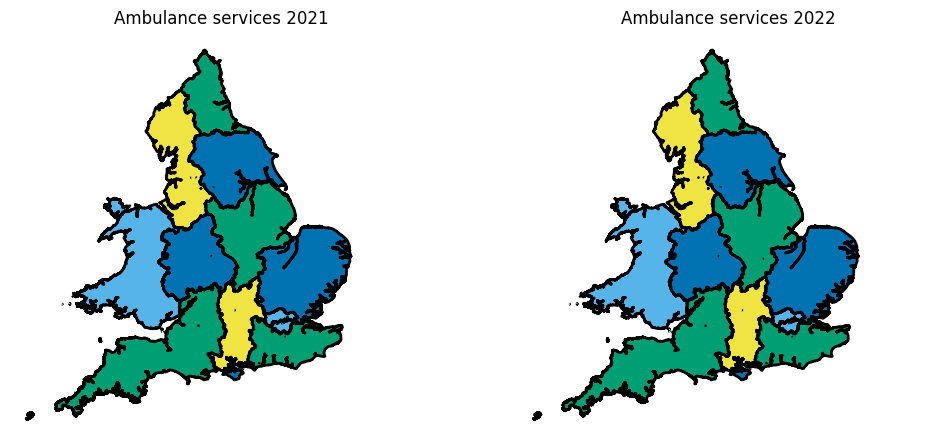

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

gdf_ambo21_lsoa.plot(
    ax=axs[0],
    color=gdf_ambo21_lsoa['amb_colour'],
    edgecolor='k',
    linewidth=2,
)

gdf_ambo22_lsoa.plot(
    ax=axs[1],
    color=gdf_ambo22_lsoa['amb_colour'],
    edgecolor='k',
    linewidth=2,
)

for ax in axs:
    ax.axis('off')
    ax.set_xlim(ax.get_xlim()[0], 800000)

axs[0].set_title('Ambulance services 2021')
axs[1].set_title('Ambulance services 2022')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_services_boundary_problems.png'), bbox_inches='tight')
plt.show()

### Test 1: build up ambulance 2021 using CCG 2015

Import a CCG15-ambulance service lookup that we've invented:

In [34]:
df_ccg15_ambo = pd.read_csv(os.path.join(paths.data, paths.ccg15_amb_lookup))

df_ccg15_ambo.head()

,ccg15nm,ambo21
0,"NHS Airedale, Wharfedale and Craven CCG",YAS
1,NHS Ashford CCG,SECAmb
2,NHS Aylesbury Vale CCG,SCAS
3,NHS Barking and Dagenham CCG,LAS
4,NHS Barnet CCG,LAS


Merge ambulance services into the CCG 2015 shapes:

In [35]:
gdf_ccg15_ambo21 = pd.merge(
    gdf_ccg15, df_ccg15_ambo,
    left_on='ccg15nm', right_on='ccg15nm', how='left'
)

Combine shapes in the same ambulance region:

In [36]:
gdf_ccg15_ambo21 = gdf_ccg15_ambo21.dissolve(by='ambo21')

Merge in the shape for Wales:

In [37]:
# Limit to just information that's shared across all of these ambulance gdf:
gdf_ccg15_ambo21 = gdf_ccg15_ambo21['geometry']

gdf_ccg15_ambo21.at['WAST'] = gdf_ambo21_lsoa.loc['WAST', 'geometry']

Merge in the colours:

In [38]:
gdf_ccg15_ambo21 = pd.merge(gdf_ccg15_ambo21, amb_colour, left_index=True, right_index=True, how='left')

Plot the resulting shapes:

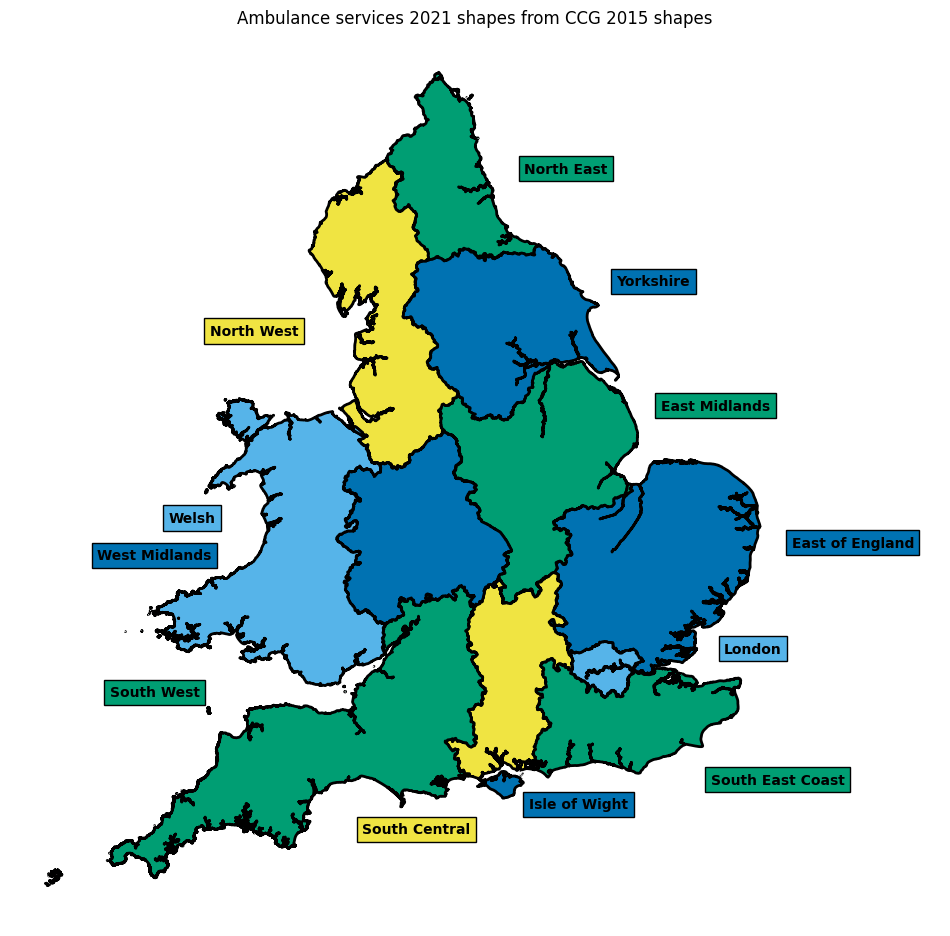

In [39]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_ccg15_ambo21.plot(
    ax=ax,
    color=gdf_ccg15_ambo21['amb_colour'],
    edgecolor='k',
    linewidth=2
)

plot_annotations(df_annotations)

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance services 2021 shapes from CCG 2015 shapes')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service21_alt_ccg15shapes.png'), bbox_inches='tight')
plt.show()

__Result:__ The visible specks have gone.

### Test 2: build up ambulance 2022 using mixed SICBL 2022 and CCG 2015

Import a SICBL22-ambulance service lookup that we've invented:

In [40]:
# Build ambulance service shapes from SICBL 2022:
df_sicbl22_ambo = pd.read_csv(os.path.join(paths.data, paths.sicbl22_amb_lookup))

df_sicbl22_ambo.head()

,LOC22CD,LOC22NM,ambo22
0,E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,EEAST
1,E38000049,NHS Hertfordshire and West Essex ICB - 06K,EEAST
2,E38000079,NHS Hertfordshire and West Essex ICB - 06N,EEAST
3,E38000197,NHS Hertfordshire and West Essex ICB - 07H,EEAST
4,E38000106,NHS Mid and South Essex ICB - 06Q,EEAST


Merge ambulance services into the SICBL22 shapes:

In [41]:
gdf_sicbl22_ambo22 = pd.merge(
    gdf_sicbl22, df_sicbl22_ambo,
    left_on='SICBL22CD', right_on='LOC22CD', how='left'
)

Remove problem counties:

In [42]:
mask = gdf_sicbl22_ambo22['SICBL22NM'].isin([
    'NHS Bedfordshire, Luton and Milton Keynes ICB - M1J4Y',
    'NHS Hampshire and Isle Of Wight ICB - D9Y0V'  # note "Of" vs "of" in name
])

gdf_sicbl22_ambo22 = gdf_sicbl22_ambo22.loc[~mask].copy()

Only keep columns that will be shared with the CCG 2015 data:

In [43]:
gdf_sicbl22_ambo22 = gdf_sicbl22_ambo22[['geometry', 'ambo22']]

Prepare the CCG 2015 data for the problem counties:

In [44]:
# Import CCG 2015 boundaries:
gdf_ccg15 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

gdf_amb15 = pd.merge(gdf_ccg15, df_ccg15_ambo, on='ccg15nm', how='left')

mask = gdf_amb15['ccg15nm'].isin([
    # Hampshire:
    'NHS Isle of Wight CCG',
    'NHS West Hampshire CCG',
    'NHS Southampton CCG',
    'NHS Fareham and Gosport CCG',
    'NHS South Eastern Hampshire CCG',
    'NHS North Hampshire CCG',
    # Bedfordshire:
    'NHS Bedfordshire CCG',
    'NHS Luton CCG',
    'NHS Milton Keynes CCG',
])
gdf_amb15 = gdf_amb15.loc[mask].copy()

gdf_amb15 = gdf_amb15[['geometry', 'ambo21']]

gdf_amb15 = gdf_amb15.rename(columns={'ambo21': 'ambo22'})

Add in CCG 2015 shapes for the problem counties:

In [45]:
# n.b. make sure both geodataframe have the same coordinate reference system
gdf_sicbl22_ambo22 = pd.concat((gdf_sicbl22_ambo22, gdf_amb15), axis='rows')

Merge ambulance region shapes:

In [46]:
# Merge ccg boundaries:
gdf_sicbl22_ambo22 = gdf_sicbl22_ambo22.dissolve(by='ambo22')

Add in Wales shape from previously:

In [47]:
gdf_sicbl22_ambo22.at['WAST', 'geometry'] = gdf_ambo22_lsoa.loc['WAST', 'geometry']

Add in colours for plotting:

In [48]:
# Merge in colours:
gdf_sicbl22_ambo22['amb_colour'] = gdf_sicbl22_ambo22.index.map(amb_colour)

Plot the resulting shapes:

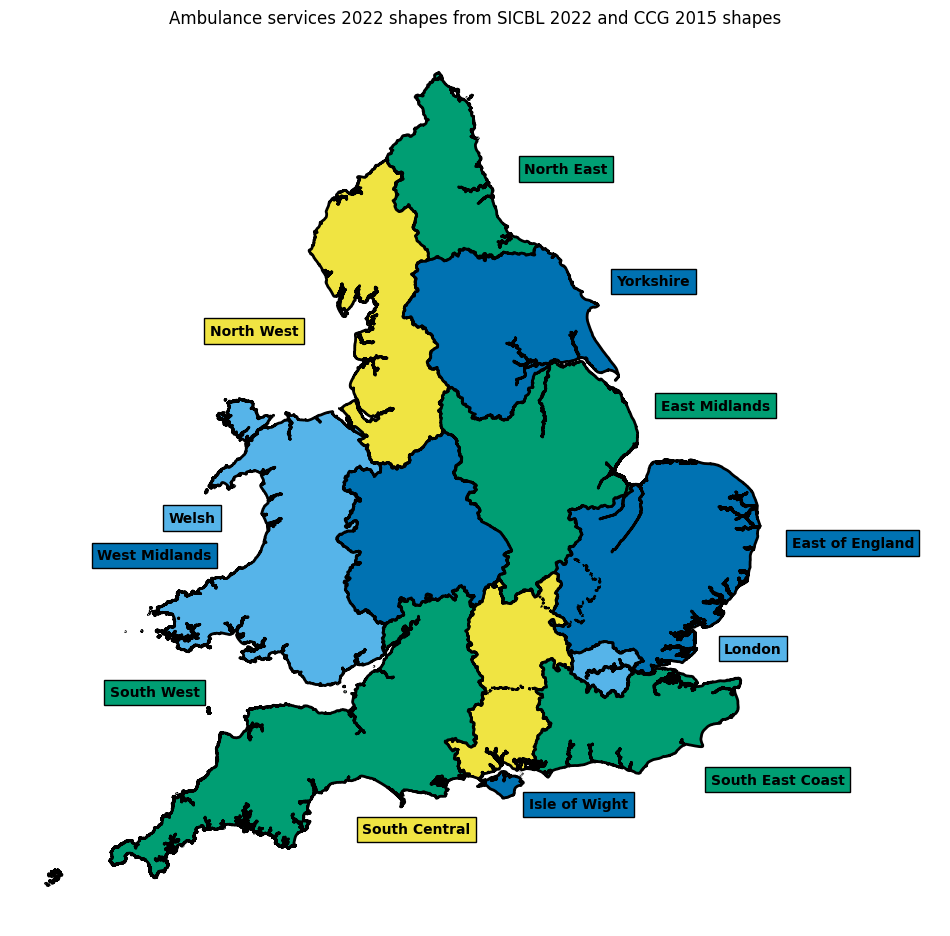

In [49]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_sicbl22_ambo22.plot(
    ax=ax,
    color=gdf_sicbl22_ambo22['amb_colour'],
    edgecolor='k',
    linewidth=2
)

plot_annotations(df_annotations)

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance services 2022 shapes from SICBL 2022 and CCG 2015 shapes')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service22_alt_sicbl22ccg15shapes.png'), bbox_inches='tight')
plt.show()

__Result:__ This process has removed most specks, but introduced new specks or lines of artefacts where the CCG 2015 shapes were swapped in.

This can be removed using a buffer, i.e. expand the whole shape by a few metres and then shrink it by the same amount:

In [50]:
gdf_sicbl22_ambo22_buff = gdf_sicbl22_ambo22.copy()

b = 10  # metres

ambo = ['SCAS', 'EEAST']
gdf_sicbl22_ambo22_buff.loc[ambo, 'geometry'] = gdf_sicbl22_ambo22_buff.loc[ambo, 'geometry'].buffer(b).buffer(-b)

Plot the resulting shapes:

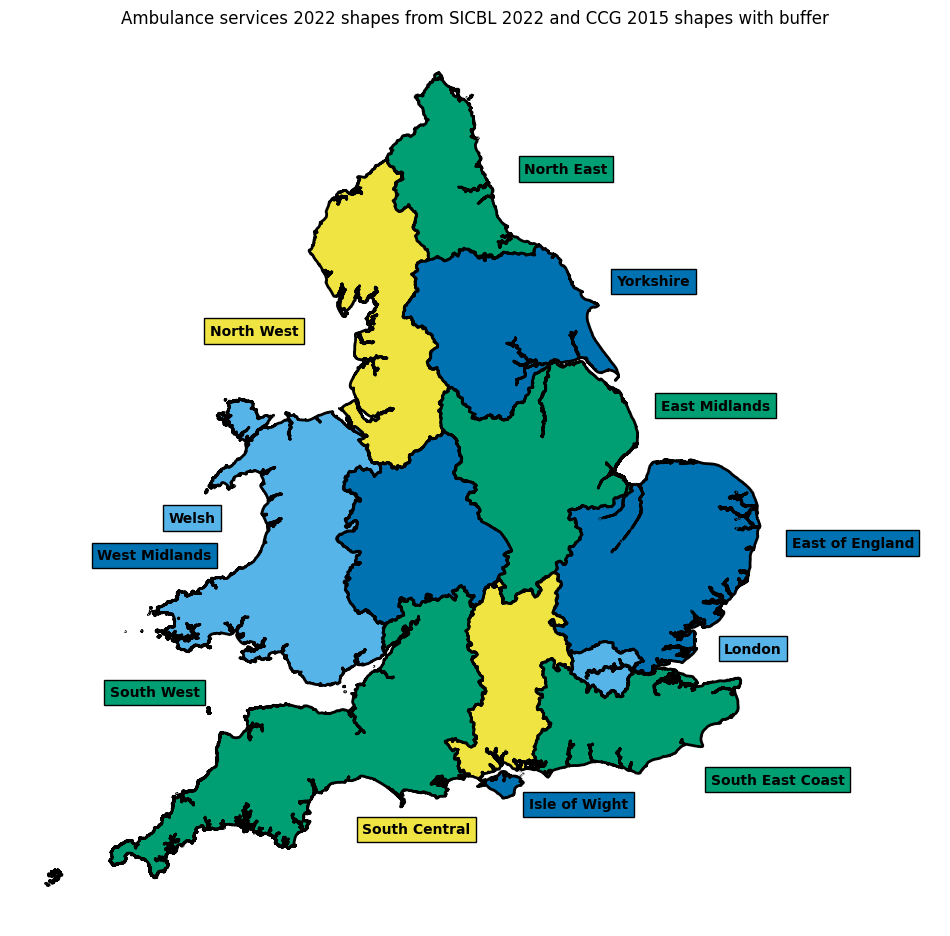

In [51]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_sicbl22_ambo22_buff.plot(
    ax=ax,
    color=gdf_sicbl22_ambo22_buff['amb_colour'],
    edgecolor='k',
    linewidth=2
)

plot_annotations(df_annotations)

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance services 2022 shapes from SICBL 2022 and CCG 2015 shapes with buffer')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service22_alt_sicbl22ccg15shapes_buffer.png'), bbox_inches='tight')
plt.show()

__Result:__ All of the specks have gone. The borders of the affected regions (SCAS and EEAST) might no longer mesh well with their surrounding regions.

### Test 3: build up ambulance 2022 by splitting off polygons

This one is possible but only for islands and would be fiddly to automate.

Start with the SICBL 2022 regions:

In [52]:
gdf_sicbl22_ambo22 = pd.merge(
    gdf_sicbl22, df_sicbl22_ambo,
    left_on='SICBL22CD', right_on='LOC22CD', how='left'
)

Make a quick plot of the cut-off points for polygons.

We can check what counts as the Isle of Wight by looking up the 2015 CCG boundaries where the Isle of Wight is separate. As well as the main island shape, the CCG also contains smaller polygons to the left (the Needles) and the top-right (presumably some sea forts).

The shapes that count as the Isle of Wight all have their most northernly point below the dashed line _and_ their most southernly point below the dotted line.

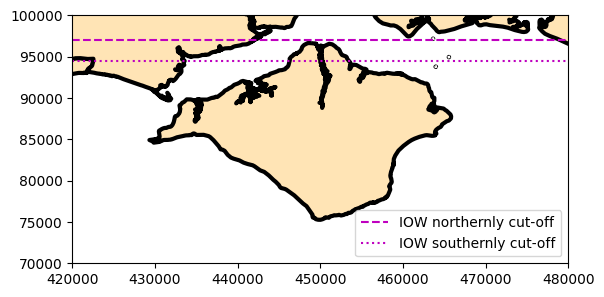

In [53]:
fig, ax = plt.subplots()

gdf_sicbl22_ambo22.plot(
    ax=ax,
    facecolor='Moccasin',
    edgecolor='k',
    linewidth=3
)

ax.set_xlim(420000, 480000)
ax.set_ylim(70000, 100000)

ax.axhline(97000, color='m', linestyle='--', label='IOW northernly cut-off')
ax.axhline(94500, color='m', linestyle=':', label='IOW southernly cut-off')

ax.legend(loc='lower right')

plt.show()

Decide which polygons belong to the Isle of Wight and which belong to mainland Hampshire:

In [54]:
# Pick out the polygons in the Hampshire SICBL:
hants_loc = gdf_sicbl22_ambo22['SICBL22NM'] == 'NHS Hampshire and Isle Of Wight ICB - D9Y0V'
hants_polys = gdf_sicbl22_ambo22.loc[hants_loc]['geometry'].explode()

# Pick out the y-coordinates of each polygon:
hants_polys_y = [p.exterior.coords.xy[1] for p in hants_polys.values]

# Pick out the most northernly y-coordinate of each polygon:
hants_polys_ymax = [max(ys) for ys in hants_polys_y]
# Pick out the most southernly y-coordinate of each polygon:
hants_polys_ymin = [min(ys) for ys in hants_polys_y]

# Where is the most northernly point below this value...
ymax_ref = 97000  # just above top of Isle of Wight
# ... and the most southernly point below this value:
ymin_ref = 94500  # between sea forts, see CCG 2015 allocations

# Indices of polygons meeting these conditions:
inds_iow = [i for i in range(len(hants_polys_y)) if (
    (hants_polys_ymax[i] < ymax_ref) &
    (hants_polys_ymin[i] < ymin_ref)
    )]

/tmp/ipykernel_15543/1318402095.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  hants_polys = gdf_sicbl22_ambo22.loc[hants_loc]['geometry'].explode()


Check geopandas version to see how to recombine polygons.

In 0.12.2, the function is called unary_union. In versions 15ish and later, it is called union_all.

In [55]:
gpd.__version__

'0.12.2'

Combine these Isle of Wight polygons into a MultiPolygon:

In [56]:
iow_poly = hants_polys.iloc[inds_iow].unary_union  # renamed to union_all() in geopandas X()

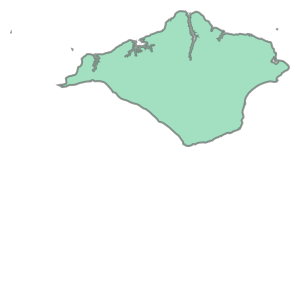

In [57]:
iow_poly

Add a new geometry row to the bottom of the main gdf with this polygon:

In [58]:
ind_new = len(gdf_sicbl22_ambo22)
gdf_sicbl22_ambo22.at[ind_new, 'geometry'] = iow_poly
gdf_sicbl22_ambo22.at[ind_new, 'ambo22'] = 'IWAS'

Combine the remaining polygons into a MultiPolygon:

In [59]:
hants_poly = hants_polys.iloc[~np.array(inds_iow)].unary_union  # renamed to union_all() in geopandas X()

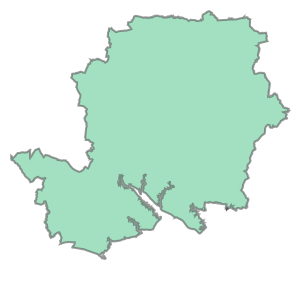

In [60]:
hants_poly

Place this polygon back into its starting location:

In [61]:
gdf_sicbl22_ambo22.at[np.where(hants_loc == True)[0][0], 'geometry'] = hants_poly
gdf_sicbl22_ambo22.at[np.where(hants_loc == True)[0][0], 'ambo22'] = 'SCAS'

Limit the geodataframe to columns we have complete information for:

In [62]:
gdf_sicbl22_ambo22 = gdf_sicbl22_ambo22[['ambo22', 'geometry']]

Now create the ambulance service areas as normal.

Merge ambulance region shapes:

In [63]:
gdf_sicbl22_ambo22 = gdf_sicbl22_ambo22.dissolve(by='ambo22')

Add in Wales shape from previously:

In [64]:
gdf_sicbl22_ambo22.at['WAST', 'geometry'] = gdf_ambo22_lsoa.loc['WAST', 'geometry']

Add in colours for plotting:

In [65]:
# Merge in colours:
gdf_sicbl22_ambo22['amb_colour'] = gdf_sicbl22_ambo22.index.map(amb_colour)

# Set placeholder "multiple" ambulance service code to blank colour:
gdf_sicbl22_ambo22.loc['multiple', 'amb_colour'] = '#00000000'

Plot the resulting shapes:

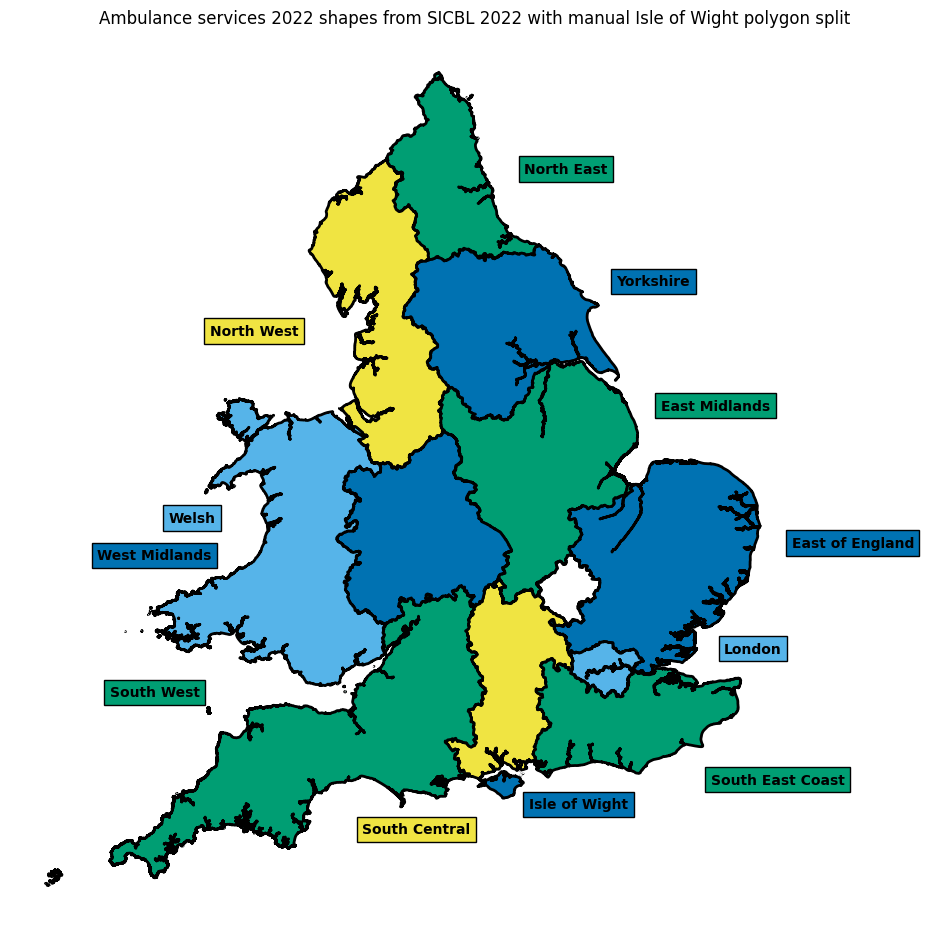

In [66]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_sicbl22_ambo22.plot(
    ax=ax,
    color=gdf_sicbl22_ambo22['amb_colour'],
    edgecolor='k',
    linewidth=2
)

plot_annotations(df_annotations)

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance services 2022 shapes from SICBL 2022 with manual Isle of Wight polygon split')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service22_alt_sicbl22shapes_iowpolygonsplit.png'), bbox_inches='tight')
plt.show()

Note that Bedfordshire is blank in this map because we didn't do anything to fix the multiple ambulance service areas in that SICBL this time.

__Result:__ The Isle of Wight has been split off from the rest of the Hampshire SICBL while keeping the exact same geometry as the starting combined geometry.